# Lesson 4 Notebook: BERT Endeavors

**Description:** After some setup for our standard IMDB movie classification task we will explore BERT (obtained from the Huggingface Transformer library) and apply it to text classification (in one way). 

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup) 
  * 2. [Data Acquisition](#dataAcquisition)  
  * 3. [BERT Basics](#bertBasics)
    * 3.1 [Tokenization](#tokenization)
    * 3.2 [Model Structure & Output](#modelOutput)
    * 3.3 [Context Based Embeddings with BERT](#contextualEmbeddings)
  * 4. [Text Classification with BERT (using the Pooled Output)](#BERTClassification)
    * 4.1 [Class Exercise](#classExercise)

  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2022-fall-main/blob/master/materials/lesson_notebooks/lesson_4_BERT.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>

## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally. 

In [1]:
!pip install tensorflow-datasets --quiet

pydot is also helpful, along with **graphviz**.

In [2]:
!pip install pydot --quiet

For BERT and other Transformer libraries we generally use Huggingface's implementations:

In [3]:
!pip install transformers --quiet

     |████████████████████████████████| 4.7 MB 6.4 MB/s 
     |████████████████████████████████| 120 kB 50.2 MB/s 
     |████████████████████████████████| 6.6 MB 41.5 MB/s 


Ready to do the imports.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds



import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

For the Transformer library we need to import the **tokenizer** and the TensorFlow **model**:

In [5]:
from transformers import BertTokenizer, TFBertModel

We then continue for now as we have before.

Below is a helper function to plot histories.

In [6]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

A small function calculating the cosine similarity may also come in handy:

In [7]:
def cosine_similarities(vecs):
    for v_1 in vecs:
        similarities = ''
        for v_2 in vecs:
            similarities += ('\t' + str(np.dot(v_1, v_2)/np.sqrt(np.dot(v_1, v_1) * np.dot(v_2, v_2)))[:4])
        print(similarities)

[Return to Top](#returnToTop)  
<a id = 'dataAcquisition'></a>

## 2. Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [8]:
train_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteY2MIUO/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteY2MIUO/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteY2MIUO/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [9]:
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

In [10]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [11]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

[Return to Top](#returnToTop)  
<a id = 'bertBasics'></a>
## 3. BERT Basics

We now need to settle on the pre-trained BERT model we want to use. We will leverage **'bert-base-cased'**.

We need to create the corresponding model and tokenizer:

In [12]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


[Return to Top](#returnToTop)  
<a id = 'tokenization'></a>

### 3.1 Tokenization

Tokenization with BERT is interesting. To minimize the number of unknown words, BERT (like most pre-trained transformer models) uses a **subword** model for tokenization. We will see what that means in a second.

Let's start with something simple:

In [13]:
bert_tokenizer.tokenize('This is great!')

['This', 'is', 'great', '!']

Ok, that is as expected. What about:

In [14]:
bert_tokenizer.tokenize('This tree is 1253 years old.')

['This', 'tree', 'is', '125', '##3', 'years', 'old', '.']

or

In [15]:
bert_tokenizer.tokenize('Pneumonia can be very serious.')

['P', '##ne', '##um', '##onia', 'can', 'be', 'very', 'serious', '.']

Ouch! Many more complex terms are not in BERT's vocabulary and are split up.

**Question:** in what type of NLP problems can this lead to complications?

Next, how do we generate the BERT input with its tokenizer? Fortunately, by now Huggingface's tokenizer implementation makes this rather straightforward:

In [16]:
bert_tokenizer(['This is great!'])

{'input_ids': [[101, 1188, 1110, 1632, 106, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1]]}

To make sure we do this correctly though we may want to specify that we want to have the inputs for TensorFlow (vs. PyTorch), and we may want to do some padding:

In [17]:
bert_input = bert_tokenizer(['This is great!', 'This is terrible!'], 
              max_length=10,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

bert_input

{'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[ 101, 1188, 1110, 1632,  106,  102,    0,    0,    0,    0],
       [ 101, 1188, 1110, 6434,  106,  102,    0,    0,    0,    0]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], dtype=int32)>}

What do we notice? Look at shapes and values. Does everything make sense?

[Return to Top](#returnToTop)  
<a id = 'modelOutput'></a>

### 3.2 Model Structure & Output

Where we have familiarized ourselves with the tokenization, we can now turn to the model and its output. How does that work? Simple!

In [18]:
len(bert_model.weights)

199

Let's look at the first 3 of these:

In [19]:
bert_model.weights[0]

<tf.Variable 'tf_bert_model/bert/embeddings/word_embeddings/weight:0' shape=(28996, 768) dtype=float32, numpy=
array([[-0.00054784, -0.04156886,  0.01308366, ..., -0.0038919 ,
        -0.0335485 ,  0.0149841 ],
       [ 0.01688265, -0.03106827,  0.0042053 , ..., -0.01474032,
        -0.03561099, -0.0036223 ],
       [-0.00057234, -0.02673604,  0.00803954, ..., -0.01002474,
        -0.0331164 , -0.01651673],
       ...,
       [-0.00643814,  0.01658491, -0.02035619, ..., -0.04178825,
        -0.049201  ,  0.00416085],
       [-0.00483562, -0.00267701, -0.02901638, ..., -0.05116647,
         0.00449265, -0.01177113],
       [ 0.03134822, -0.02974372, -0.02302896, ..., -0.01454749,
        -0.05249038,  0.02843569]], dtype=float32)>

In [20]:
bert_model.weights[1]

<tf.Variable 'tf_bert_model/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32, numpy=
array([[-3.6974233e-03,  1.7510093e-03, -1.4998456e-05, ...,
         4.1503753e-03, -4.3169265e-03,  2.5677346e-04],
       [-2.4836401e-03, -3.9493470e-03, -3.2805414e-03, ...,
        -2.4496014e-03, -2.2277145e-03, -2.3139343e-03]], dtype=float32)>

In [21]:
bert_model.weights[2]

<tf.Variable 'tf_bert_model/bert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 0.02344714,  0.00516326, -0.013507  , ...,  0.00153387,
         0.01396566,  0.00978599],
       [-0.02690891, -0.00475334, -0.00550656, ...,  0.00586852,
         0.00464536, -0.00547428],
       [-0.01394941, -0.00832889,  0.00383158, ...,  0.00617752,
         0.00074595, -0.01051977],
       ...,
       [ 0.0049373 ,  0.01553355,  0.02107639, ..., -0.00957435,
         0.02251508,  0.01383893],
       [ 0.01732728, -0.02141069, -0.00283472, ..., -0.02397991,
        -0.00158155, -0.01289534],
       [ 0.00196406, -0.01695957,  0.00028094, ...,  0.00183421,
        -0.01463418, -0.00022347]], dtype=float32)>

What are those?

And let's make sure that we look at more layers in class...


Now let's turn to the output.

In [22]:
bert_output = bert_model(bert_input)
bert_output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(2, 10, 768), dtype=float32, numpy=
array([[[ 0.31789976,  0.35246533,  0.15059772, ..., -0.17058682,
          0.35169625,  0.01252151],
        [ 0.29476935, -0.09967349,  0.6394639 , ..., -0.03713128,
          0.2188458 ,  0.35178185],
        [ 0.15745711,  0.6033653 ,  0.7143257 , ...,  0.08226325,
          0.3010641 ,  0.63735574],
        ...,
        [-0.08408143,  0.21920018,  0.30455425, ..., -0.08951651,
          0.3235188 ,  0.26547542],
        [ 0.24848086, -0.03157465,  0.32583147, ..., -0.10880905,
          0.4849399 ,  0.05661329],
        [ 0.22492436, -0.07156707,  0.20357618, ...,  0.04799673,
          0.44845217,  0.15163939]],

       [[ 0.33174518,  0.38341546,  0.08286644, ..., -0.22092693,
          0.24292818, -0.13691893],
        [ 0.32388812, -0.04733384,  0.6686549 , ..., -0.00434734,
          0.34234923,  0.35666344],
        [ 0.24995096,  0.7461109 ,  0.35974276, ..

Let's analyze this a bit:

In [23]:
print('Shape of first BERT output: ', bert_output[0].shape)
print('Shape of second BERT output: ', bert_output[1].shape)

Shape of first BERT output:  (2, 10, 768)
Shape of second BERT output:  (2, 768)


What does that mean? Are the dimensions correct? Why are there 2 outputs? Let's discuss in class. You can (and should!) also go to https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertModel and read the documentation. REALLY(!) critical.

[Return to Top](#returnToTop)  
<a id = 'contextualEmbeddings'></a>

### 3.3 Context-based Embeddings with BERT

Let's look at the word "bank" in a few contexts:

In [24]:
bert_bank_inputs = bert_tokenizer(["I need to bring my money to the bank today",
                                  "I will need to bring my money to the bank tomorrow",
                                  "I had to bank into a turn",
                                  "The bank teller was very nice" ],
                                padding=True,
                                return_tensors='tf')

bert_bank_inputs

{'input_ids': <tf.Tensor: shape=(4, 13), dtype=int32, numpy=
array([[ 101,  146, 1444, 1106, 2498, 1139, 1948, 1106, 1103, 3085, 2052,
         102,    0],
       [ 101,  146, 1209, 1444, 1106, 2498, 1139, 1948, 1106, 1103, 3085,
        4911,  102],
       [ 101,  146, 1125, 1106, 3085, 1154,  170, 1885,  102,    0,    0,
           0,    0],
       [ 101, 1109, 3085, 1587, 1200, 1108, 1304, 3505,  102,    0,    0,
           0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(4, 13), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4, 13), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], dtype=int32)

Next, we will get the outputs and extract the word vectors for bank in each of these sentences:

In [25]:
bert_bank_outputs = bert_model(bert_bank_inputs)

bank_1 = bert_bank_outputs[0][0, 9]
bank_2 = bert_bank_outputs[0][1, 10]
bank_3 = bert_bank_outputs[0][2, 4]
bank_4 = bert_bank_outputs[0][3, 2]

banks = [bank_1, bank_2, bank_3, bank_4]

Where are those numbers coming from?

Finally, we obtain the cosine similarities between the 4 vectors (from left to right and top to bottom we iterate through our vectors and report the cosine similarity):

In [26]:
cosine_similarities(banks)

	1.0	0.99	0.59	0.86
	0.99	1.0	0.59	0.87
	0.59	0.59	1.0	0.62
	0.86	0.87	0.62	1.0


Does this look right?

[Return to Top](#returnToTop)  
<a id = 'BERTClassification'></a>

# 4. Text Classification with BERT (using the Pooled Output)

The BERT model returns two values. The second one is the pooled output, with is the output of the [CLS] token where another linear layer is added on top followed by a tanh. This output can be used for classification purposes.

Let us create the data. More will be discussed in class. (We can limit the training and test data sizes for expedience in class.)

In [27]:
# BERT Tokenization of training and test data

num_train_examples = 20000      # set number of train examples - 1500 for realtime demo
num_test_examples = 5000        # set number of test examples - 500 for realtime demo

max_length = 128                 # set max_length

all_train_examples = [x.decode('utf-8') for x in train_examples.numpy()]
all_test_examples = [x.decode('utf-8') for x in test_examples.numpy()]

x_train = bert_tokenizer(all_train_examples[:num_train_examples],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = train_labels[:num_train_examples]

x_test = bert_tokenizer(all_test_examples[:num_test_examples],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = test_labels[:num_test_examples]

Now we define the model...

In [28]:
def create_bert_classification_model(bert_model,
                                     train_layers=-1,
                                     hidden_size = 200, 
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes
    """
    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
          
        
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooled_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [29]:
bert_classification_model = create_bert_classification_model(bert_model, train_layers=-1)

In [30]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

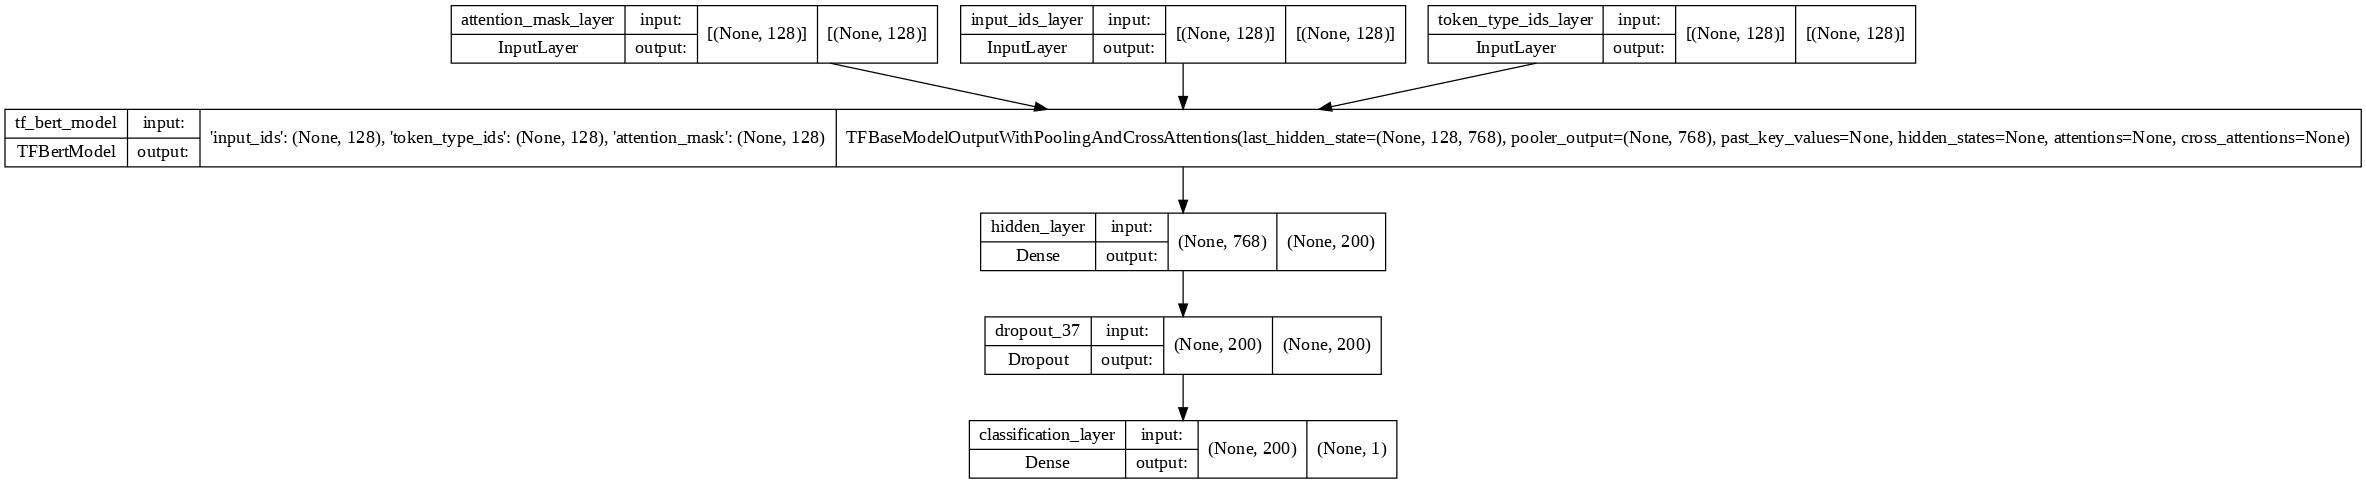

In [31]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

... and train it!  (This takes a few minutes; we might only be able to train for one epoch in the live session.)

In [32]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=2
)  

Epoch 1/2
625/625 [==============================] - 246s 381ms/step - loss: 0.6940 - accuracy: 0.5602 - val_loss: 0.6529 - val_accuracy: 0.6406
Epoch 2/2
625/625 [==============================] - 234s 375ms/step - loss: 0.6566 - accuracy: 0.6131 - val_loss: 0.6429 - val_accuracy: 0.6456


How well does it work? Can we do better? In the code above, we trained the extra hidden and classification layers that we added on top of BERT for our task. But we froze the BERT model (set trainable=False) so we're leaving the pre-trained BERT layers as-is and only our dense layer is learning.
 
[Return to Top](#returnToTop)  
<a id = 'classExercise'></a>

### 4.1 Class Exercise

In this notebook we're using a transformed version of the CLS token (called the pooled output) from the BERT model, which was pre-trained using the next sentence prediction task. It might not capture the useful context from the sentence that we need for our task. So we might need to unfreeze some of the pre-trained BERT layers and update their weights (fine-tune them) for our task.

We'll use the parameter "train_layers" in the model building function above. What if we just set train_layers=4, to unfreeze the top four layers of the BERT model? What if we set train_layers=12 to unfreeze all of the BERT transformer layers? Does some fine-tuning help? Does too much overfit?

In [33]:
bert_classification_model = create_bert_classification_model(bert_model, train_layers=4)

bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=2
)

Streaming output truncated to the last 5000 lines.
        2.07753330e-02,  2.38831174e-02,  9.08413343e-03, -3.89619321e-02,
       -1.92516614e-02,  1.33864451e-02, -1.81660727e-02, -6.88554021e-03,
       -3.77942459e-03,  1.78378094e-02, -9.20239277e-03, -2.33722907e-02,
       -2.01940686e-02, -3.05929650e-02,  1.97708644e-02, -1.58214495e-02,
        1.30406199e-02, -1.56359393e-02, -3.60345840e-02,  1.25259859e-03,
       -2.98842974e-03,  2.33973712e-02, -7.96821341e-03,  2.41319445e-04,
        1.51506402e-02, -2.23207232e-02, -9.98846442e-03,  2.55850482e-05,
        5.58562623e-03, -7.39624212e-03, -1.09900278e-03, -1.04914252e-02,
        1.94049180e-02,  1.09289931e-02,  4.71671997e-03, -1.35120042e-02,
        2.42945757e-02, -7.28734117e-03, -3.60639044e-03,  4.82465373e-03,
        2.98846141e-02, -1.38945524e-02,  1.46997683e-02, -2.58133770e-03,
       -2.63739806e-02, -1.48658501e-03, -6.29257457e-03,  3.04890610e-02,
        6.66555110e-03, -1.25874383e-02,  3.66636

In [34]:
bert_classification_model = create_bert_classification_model(bert_model, train_layers=12)

bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=2
)

retrain layers:  ['_11', '_10', '_9', '_8', '_7', '_6', '_5', '_4', '_3', '_2', '_1', '_0']
freezing:  <tf.Variable 'tf_bert_model/bert/embeddings/word_embeddings/weight:0' shape=(28996, 768) dtype=float32, numpy=
array([[-0.00054784, -0.04156886,  0.01308366, ..., -0.0038919 ,
        -0.0335485 ,  0.0149841 ],
       [ 0.01688265, -0.03106827,  0.0042053 , ..., -0.01474032,
        -0.03561099, -0.0036223 ],
       [-0.00057234, -0.02673604,  0.00803954, ..., -0.01002474,
        -0.0331164 , -0.01651673],
       ...,
       [-0.00643814,  0.01658491, -0.02035619, ..., -0.04178825,
        -0.049201  ,  0.00416085],
       [-0.00483562, -0.00267701, -0.02901638, ..., -0.05116647,
         0.00449265, -0.01177113],
       [ 0.03134822, -0.02974372, -0.02302896, ..., -0.01454749,
        -0.05249038,  0.02843569]], dtype=float32)>
freezing:  <tf.Variable 'tf_bert_model/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32, numpy=
array([[-3.6974233e-03,  1.75

And that is one way to do text classification with BERT. There are multiple ways (see Assignment 2.)